## Description:
Train a CNN on structured-grid HDF5 snapshots and predict the next time step.


In [1]:
from __future__ import annotations
from pathlib import Path
import os
os.chdir("../../..")
import re
import yaml
import numpy as np
import h5py

from mpi4py import MPI

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset

comm = MPI.COMM_WORLD
rank = comm.rank


In [2]:
PROJECT_ROOT = Path.cwd().resolve()
CONFIG_PATH = PROJECT_ROOT / "notebooks" / "case_studies" / "CNN" / "CNN.yaml"
CFG = yaml.safe_load(CONFIG_PATH.read_text(encoding="utf-8"))

TIME_STEP_START = CFG.get("TIME_STEP_START", None)
TIME_STEP_END = CFG.get("TIME_STEP_END", None)
PRED_TIME_STEP_START = CFG.get("PRED_TIME_STEP_START", None)
PRED_TIME_STEP_END = CFG.get("PRED_TIME_STEP_END", None)

PHI = float(CFG["PHI"])
LAT_SIZE = str(CFG["LAT_SIZE"])
BASE_DIR = PROJECT_ROOT / Path(CFG["BASE_DIR"])
CASE_DIR = CFG.get("CASE_DIR", None)

OUTPUT_FILE_STEM = str(CFG.get("OUTPUT_FILE_STEM", "structured_fields"))
FILE_INDEX_PAD = int(CFG.get("FILE_INDEX_PAD", 5))
POINTS_FNAME = str(CFG.get("POINTS_FNAME", "points.hdf5"))

FIELD_NAME = str(CFG["FIELD_NAME"])
USE_TIME_ATTR = bool(CFG.get("USE_TIME_ATTR", True))

if CASE_DIR:
    case_dir = PROJECT_ROOT / Path(CASE_DIR)
else:
    phi_tag = f"phi_{PHI:.2f}"
    lat_tag = f"h400x{LAT_SIZE}_ref"
    case_dir = BASE_DIR / phi_tag / lat_tag

points_path = case_dir / POINTS_FNAME
coords_path = case_dir / f"coordinates_{OUTPUT_FILE_STEM}.hdf5"
GRID_SHAPE = None

if rank == 0:
    print(f"Case dir: {case_dir}")

def _file_index(path: Path) -> int:
    m = re.search(r"(\d+)$", path.stem)
    return int(m.group(1)) if m else 0

def _file_time(path: Path) -> float:
    if USE_TIME_ATTR:
        try:
            with h5py.File(path, "r") as f:
                t = f.attrs.get("time", None)
            if t is not None:
                return float(t)
        except OSError:
            pass
    return float(_file_index(path))

def _build_files(step_start, step_end):
    if step_start is None or step_end is None:
        return None
    s0 = int(step_start)
    s1 = int(step_end)
    steps = list(range(s0, s1 + 1))
    out = [
        case_dir / f"{OUTPUT_FILE_STEM}{str(ts).zfill(FILE_INDEX_PAD)}.hdf5"
        for ts in steps
    ]
    return [p for p in out if p.exists()]

train_files = _build_files(TIME_STEP_START, TIME_STEP_END)
if train_files is None:
    train_files = sorted(case_dir.glob(f"{OUTPUT_FILE_STEM}*.hdf5"))

if not train_files:
    raise FileNotFoundError(f"No HDF5 files found in {case_dir}")

train_info = [(_file_time(p), p) for p in train_files]
train_info.sort(key=lambda x: x[0])
times = [t for t, _ in train_info]
files = [p for _, p in train_info]

pred_files = []
pred_times = []
if PRED_TIME_STEP_START is not None and PRED_TIME_STEP_END is not None:
    pred_files = _build_files(PRED_TIME_STEP_START, PRED_TIME_STEP_END)
    if not pred_files:
        raise FileNotFoundError(f"No prediction HDF5 files found in {case_dir}")
    pred_info = [(_file_time(p), p) for p in pred_files]
    pred_info.sort(key=lambda x: x[0])
    pred_times = [t for t, _ in pred_info]
    pred_files = [p for _, p in pred_info]

if rank == 0:
    print(f"Training files: {len(files)}. time range: {times[0]} -> {times[-1]}")
    if pred_files:
        print(f"Prediction files: {len(pred_files)}. time range: {pred_times[0]} -> {pred_times[-1]}")
    print(f"Field: {FIELD_NAME}")

def _read_field(path: Path, field_name: str) -> np.ndarray:
    with h5py.File(path, "r") as f:
        if field_name not in f:
            raise KeyError(
                f"Field '{field_name}' not found in {path.name}."
            )
        data = f[field_name][:]
    return data

def _load_grid_shape() -> tuple[int, ...] | None:
    global GRID_SHAPE
    if GRID_SHAPE is not None:
        return GRID_SHAPE
    for cand in (points_path, coords_path):
        if cand is None:
            continue
        if not Path(cand).exists():
            continue
        try:
            with h5py.File(cand, "r") as f:
                for key in ("x", "y", "z"):
                    if key in f:
                        GRID_SHAPE = f[key].shape
                        return GRID_SHAPE
        except OSError:
            continue
    return None

def _to_channels(arr: np.ndarray) -> tuple[np.ndarray, tuple[int, ...]]:
    if arr.ndim == 1:
        grid_shape = _load_grid_shape()
        if grid_shape is None:
            raise ValueError(
                "Field is 1D; could not infer grid shape. Provide points.hdf5 or coordinates_*.hdf5."
            )
        if arr.size != int(np.prod(grid_shape)):
            raise ValueError(
                f"Field size {arr.size} does not match grid size {int(np.prod(grid_shape))}."
            )
        arr = arr.reshape(grid_shape)
    if arr.ndim == 2:
        return arr[None, ...], arr.shape
    if arr.ndim == 3:
        return np.transpose(arr, (2, 0, 1)), arr.shape
    raise ValueError(f"Unsupported field ndim={arr.ndim}.")

fields = []
field_shape = None
channel_shape = None
for p in files:
    data = _read_field(p, FIELD_NAME)
    ch, shape = _to_channels(data)
    if field_shape is None:
        field_shape = shape
        channel_shape = ch.shape
    else:
        if shape != field_shape:
            raise ValueError(
                f"Field shape mismatch: {shape} vs {field_shape} at {p.name}"
            )
        if ch.shape != channel_shape:
            raise ValueError(
                f"Channel shape mismatch: {ch.shape} vs {channel_shape} at {p.name}"
            )
    fields.append(ch)

X = np.stack(fields, axis=0).astype(np.float32)
T, C, H, W = X.shape

X_pred = None
T_pred = 0
if pred_files:
    pred_fields = []
    for p in pred_files:
        data = _read_field(p, FIELD_NAME)
        ch, shape = _to_channels(data)
        if shape != field_shape:
            raise ValueError(
                f"Prediction field shape mismatch: {shape} vs {field_shape} at {p.name}"
            )
        if ch.shape != channel_shape:
            raise ValueError(
                f"Prediction channel shape mismatch: {ch.shape} vs {channel_shape} at {p.name}"
            )
        pred_fields.append(ch)
    X_pred = np.stack(pred_fields, axis=0).astype(np.float32)
    T_pred = X_pred.shape[0]

if rank == 0:
    print(f"Loaded X (train): T={T}, C={C}, H={H}, W={W}")
    if pred_files:
        print(f"Loaded X_pred: T={T_pred}, C={C}, H={H}, W={W}")


Case dir: /media/alexandros/OS/Users/alexp/Documents/Bachelor Thesis/Code/data/fields/structured_grids/phi_0.40/h400x025_ref
Training files: 91. time range: 200.0 -> 290.0
Prediction files: 10. time range: 291.0 -> 300.0
Field: t
Loaded X (train): T=91, C=1, H=800, W=200
Loaded X_pred: T=10, C=1, H=800, W=200


In [3]:
# ============================================================
# Plotting: consistent style & sizing (driven by CNN.yaml)
# ============================================================
from pathlib import Path
import matplotlib.pyplot as plt


def _as_figsize(val, default=(6.8, 6.2)) -> tuple[float, float]:
    if isinstance(val, (list, tuple)) and len(val) == 2:
        try:
            return (float(val[0]), float(val[1]))
        except Exception:
            pass
    return (float(default[0]), float(default[1]))


# --- YAML-driven style knobs (shared with DMD notebook) ---
PLOT_FONT_FAMILY = str(CFG.get("PLOT_FONT_FAMILY", "Courier New"))
PLOT_FONT_SIZE = int(CFG.get("PLOT_FONT_SIZE", 20))
FIG_DPI = int(CFG.get("FIG_DPI", 250))
FIG_SIZE = _as_figsize(CFG.get("FIG_SIZE", (6.8, 6.2)), (6.8, 6.2))
FIELD_FIGSIZE = _as_figsize(CFG.get("FIELD_FIG_SIZE", FIG_SIZE), FIG_SIZE)

FIELD_CMAP = str(CFG.get("FIELD_COLORMAP", "viridis"))

LINE_WIDTH = float(CFG.get("PLOT_LINE_WIDTH", 2.2))
MARKER_SIZE = float(CFG.get("PLOT_MARKER_SIZE", 6.0))
PLOT_PAD = float(CFG.get("PLOT_PAD", 0.02))

PLOT_USE_TEX = bool(CFG.get("PLOT_USE_TEX", False))
PLOT_TEX_PREAMBLE_RAW = CFG.get("PLOT_TEX_PREAMBLE", "")
if isinstance(PLOT_TEX_PREAMBLE_RAW, (list, tuple)):
    PLOT_TEX_PREAMBLE = "\n".join(str(item) for item in PLOT_TEX_PREAMBLE_RAW if item)
else:
    PLOT_TEX_PREAMBLE = str(PLOT_TEX_PREAMBLE_RAW) if PLOT_TEX_PREAMBLE_RAW is not None else ""

# Output directory for figures
PLOT_DIR = PROJECT_ROOT / Path(CFG.get("REPORT_BASE_DIR", "report_figures/case_studies/CNN"))
PLOT_DIR.mkdir(parents=True, exist_ok=True)

# File formats to write (keep minimal by default)
PLOT_FORMATS = CFG.get("PLOT_FORMATS", ["png", "pdf"])
if isinstance(PLOT_FORMATS, str):
    PLOT_FORMATS = [PLOT_FORMATS]
PLOT_FORMATS = [str(x).lower().lstrip('.') for x in PLOT_FORMATS]


def apply_plot_style() -> None:
    params = {
        "font.family": PLOT_FONT_FAMILY,
        "font.size": PLOT_FONT_SIZE,
        "axes.titlesize": PLOT_FONT_SIZE,
        "axes.labelsize": PLOT_FONT_SIZE,
        "xtick.labelsize": PLOT_FONT_SIZE,
        "ytick.labelsize": PLOT_FONT_SIZE,
        "legend.fontsize": PLOT_FONT_SIZE,
        "figure.titlesize": PLOT_FONT_SIZE,
        "axes.linewidth": 1.2,
        "lines.linewidth": LINE_WIDTH,
        "lines.markersize": MARKER_SIZE,
        "figure.dpi": FIG_DPI,
        "savefig.dpi": FIG_DPI,
        "text.usetex": PLOT_USE_TEX,
        "figure.subplot.left": 0.14,
        "figure.subplot.right": 0.86,
        "figure.subplot.bottom": 0.14,
        "figure.subplot.top": 0.96,
    }
    if PLOT_TEX_PREAMBLE:
        params["text.latex.preamble"] = PLOT_TEX_PREAMBLE
    plt.rcParams.update(params)


def new_fig(*, figsize=None, dpi=None):
    fig, ax = plt.subplots(figsize=figsize or FIG_SIZE, dpi=dpi or FIG_DPI)
    return fig, ax



def style_axes(ax, *, equal: bool = False) -> None:
    ax.set_axisbelow(True)
    ax.minorticks_on()
    ax.grid(True, which="major", linestyle="-", linewidth=0.75, alpha=0.25)
    ax.grid(True, which="minor", linestyle="-", linewidth=0.25, alpha=0.15)
    ax.tick_params(axis="both", which="both", direction="in", top=True, right=True)
    ax.tick_params(axis="both", which="major", length=6, width=1.0)
    ax.tick_params(axis="both", which="minor", length=3, width=0.8)
    for spine in ax.spines.values():
        spine.set_linewidth(1.2)
    if equal:
        style_axes(ax)


def style_colorbar(cbar, *, nbins: int = 5) -> None:
    from matplotlib.ticker import MaxNLocator
    cbar.ax.tick_params(labelsize=max(1, PLOT_FONT_SIZE - 6))
    cbar.locator = MaxNLocator(nbins=nbins)
    cbar.update_ticks()


def _fix_tricontourf(cf):
    """Remove edge seams in vector outputs."""
    if hasattr(cf, "set_rasterized"):
        cf.set_rasterized(True)
    collections = getattr(cf, "collections", None)
    if collections is None:
        collections = getattr(cf, "artists", None)
    if collections is None:
        try:
            collections = cf.get_children()
        except Exception:
            collections = []
    for coll in collections:
        if hasattr(coll, "set_edgecolor"):
            coll.set_edgecolor("none")
        if hasattr(coll, "set_linewidth"):
            coll.set_linewidth(0.0)
        if hasattr(coll, "set_antialiased"):
            coll.set_antialiased(False)

def save_plot(fig, stem: str, out_dir: Path | None = None) -> None:
    """Save figure in configured formats (match DMD layout)."""
    out_dir = PLOT_DIR if out_dir is None else Path(out_dir)
    out_dir.mkdir(parents=True, exist_ok=True)
    for fmt in PLOT_FORMATS:
        fmt = str(fmt).lower().lstrip('.')
        fpath = out_dir / f"{stem}.{fmt}"
        if fmt == "png":
            fig.savefig(fpath, dpi=FIG_DPI)
        else:
            fig.savefig(fpath)


# Optional palette (match DMD defaults; override in YAML if desired)
COLOR_DATA = str(CFG.get("COLOR_DATA", "#77b5b6"))
COLOR_DATA_EDGE = str(CFG.get("COLOR_DATA_EDGE", "#378d94"))
COLOR_PRED = str(CFG.get("COLOR_PRED", "#9671bd"))
COLOR_PRED_EDGE = str(CFG.get("COLOR_PRED_EDGE", "#6a408d"))
COLOR_NEUTRAL = str(CFG.get("COLOR_NEUTRAL", "#7e7e7e"))
COLOR_LINE = str(CFG.get("COLOR_LINE", "#8a8a8a"))

COORD_X = str(CFG.get("COORD_X", "x"))
COORD_Y = str(CFG.get("COORD_Y", "y"))

apply_plot_style()


History sweep candidates: [2, 4, 6, 8, 10]
Sweep epochs per candidate: 10
H=  2 | mean RMSE=4.915419e-01 | final RMSE=1.190333e+00
H=  4 | mean RMSE=3.798518e-01 | final RMSE=6.809969e-01
H=  6 | mean RMSE=3.894832e-01 | final RMSE=7.021000e-01
H=  8 | mean RMSE=3.609152e-01 | final RMSE=5.658155e-01
H= 10 | mean RMSE=3.636911e-01 | final RMSE=5.961805e-01


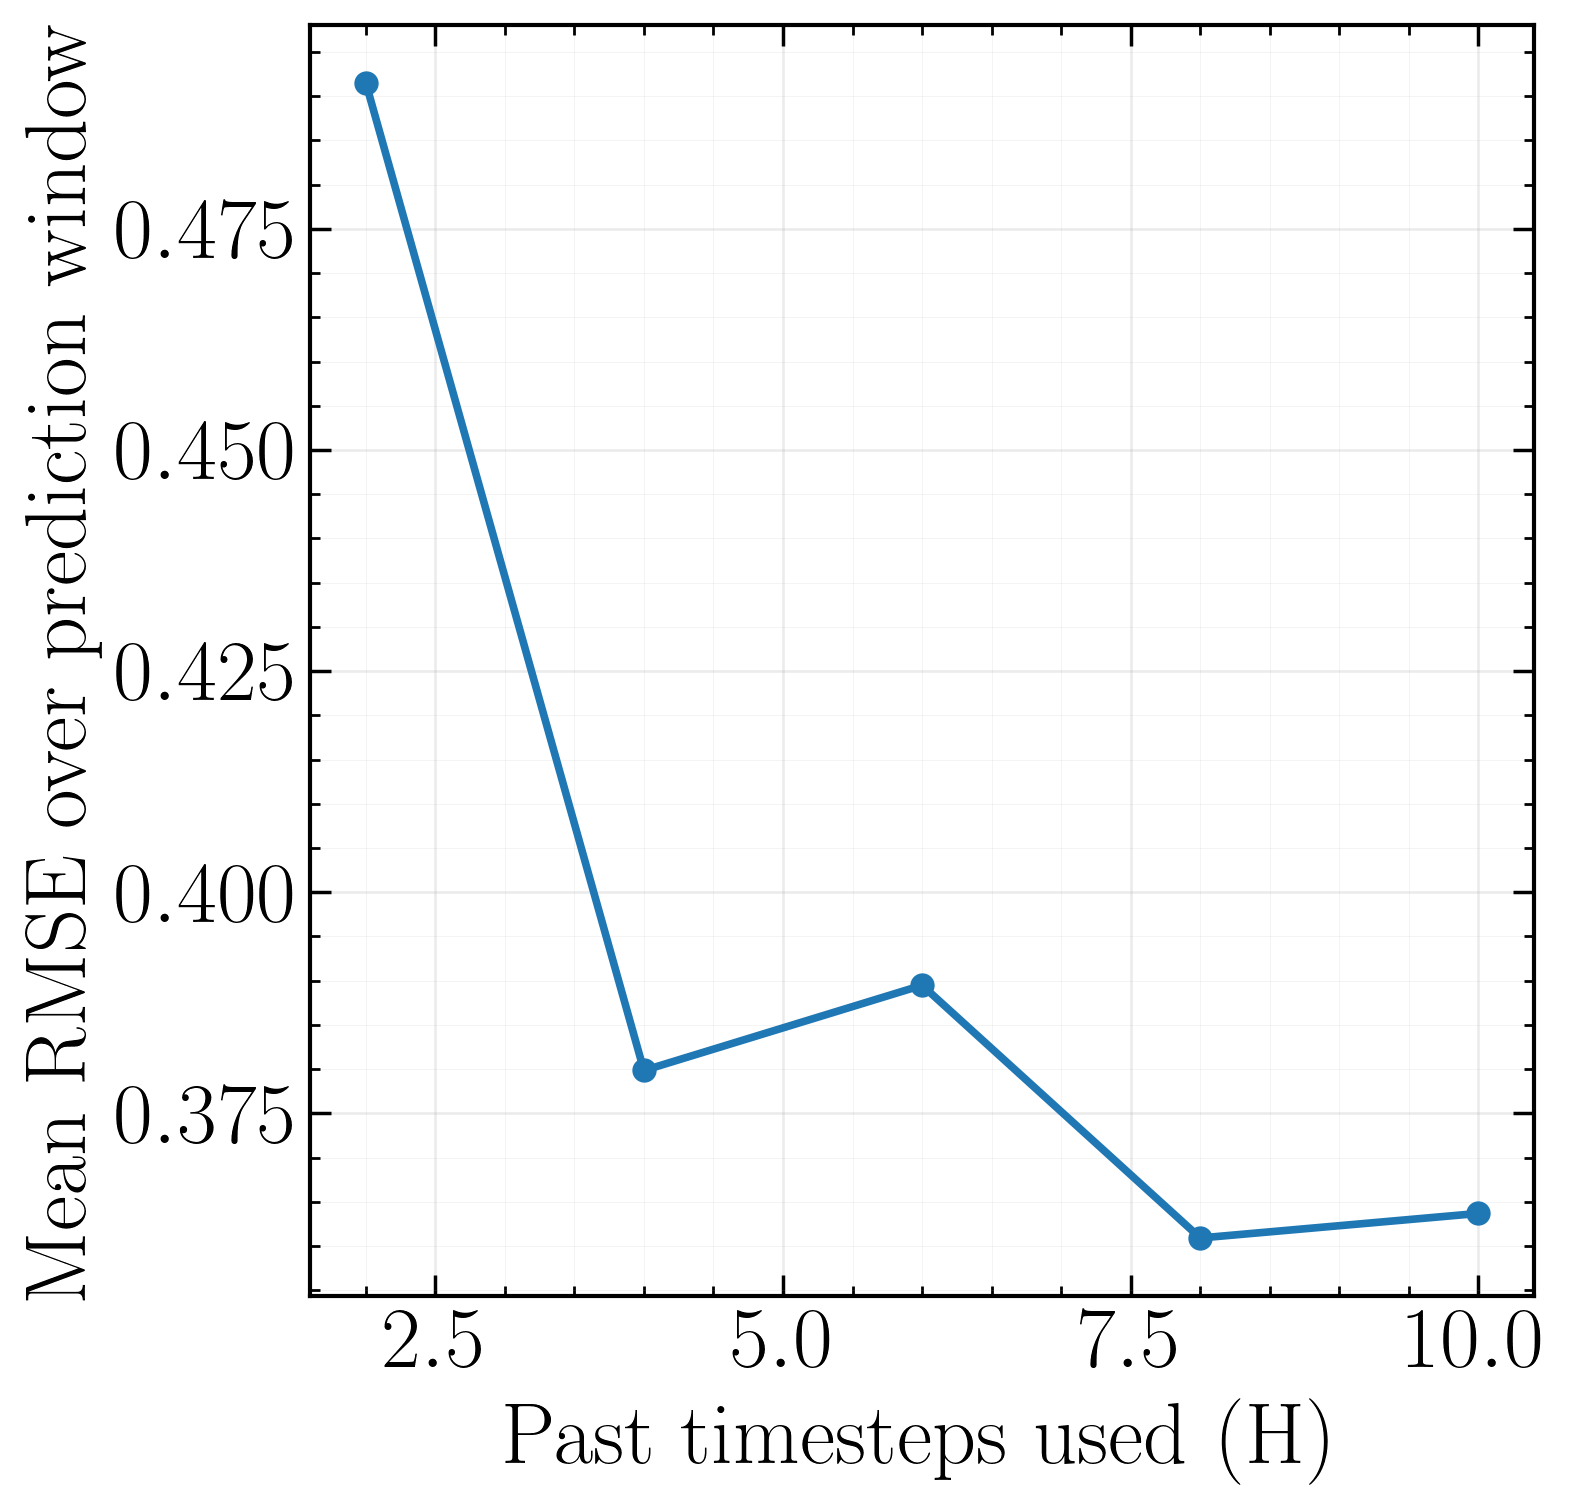

Selected BEST_HISTORY = 8


In [4]:
# ------------------------------------------------------------
# History-length study (choose HISTORY by multi-step RMSE)
# ------------------------------------------------------------
# This cell trains several CNNs with different HISTORY lengths, evaluates
# autoregressive rollout RMSE over a prediction window, then selects the best.

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset
import matplotlib.pyplot as plt

DEVICE_SWEEP = str(CFG.get("DEVICE", "cpu"))
EPS_SWEEP = float(CFG.get("EPS", 1.0e-6))
REMOVE_MEAN_SWEEP = bool(CFG.get("REMOVE_MEAN", True))
SEED_SWEEP = int(CFG.get("SEED", 0))

if DEVICE_SWEEP == "cuda" and not torch.cuda.is_available():
    DEVICE_SWEEP = "cpu"
device_sweep = torch.device(DEVICE_SWEEP)

# Candidates: optionally set in CNN.yaml as HISTORY_CANDIDATES: [1,2,4,8]
_hist_cands = CFG.get("HISTORY_CANDIDATES", None)
if _hist_cands is None:
    # sensible default set; filtered below
    _hist_cands = [1, 2, 3, 4, 5, 6, 8, 10]
HISTORY_CANDIDATES = [int(h) for h in _hist_cands]

EPOCHS_MAIN = int(CFG.get("EPOCHS", 200))
EPOCHS_STUDY = int(CFG.get("HISTORY_STUDY_EPOCHS", min(50, EPOCHS_MAIN)))
BATCH_SIZE_STUDY = int(CFG.get("HISTORY_STUDY_BATCH_SIZE", CFG.get("BATCH_SIZE", 4)))
LR_STUDY = float(CFG.get("HISTORY_STUDY_LR", CFG.get("LR", 1.0e-3)))
WEIGHT_DECAY_STUDY = float(CFG.get("HISTORY_STUDY_WEIGHT_DECAY", CFG.get("WEIGHT_DECAY", 1.0e-6)))
DROPOUT_STUDY = float(CFG.get("DROPOUT", 0.0))
HIDDEN_CHANNELS_STUDY = tuple(CFG.get("HIDDEN_CHANNELS", [16, 32, 16]))
KERNEL_SIZE_STUDY = int(CFG.get("KERNEL_SIZE", 3))
PREDICT_DELTA_STUDY = bool(CFG.get("PREDICT_DELTA", True))
TRAIN_FRACTION_STUDY = float(CFG.get("TRAIN_FRACTION", 0.8))
VAL_FRACTION_STUDY = float(CFG.get("VAL_FRACTION", 0.1))
SPLIT_STRICT_STUDY = bool(CFG.get("SPLIT_STRICT", True))
WARM_START_EVAL_STUDY = bool(CFG.get("WARM_START_EVAL", False))

# Prediction window for the sweep.
PRED_WINDOW_STUDY = CFG.get("PRED_WINDOW", None)
PRED_WINDOW_STUDY = int(PRED_WINDOW_STUDY) if PRED_WINDOW_STUDY is not None else 5
PRED_START_STUDY = CFG.get("PRED_START_INDEX", None)

# If prediction files exist, evaluate against them; otherwise evaluate on held-out test block.
USE_PRED_FILES_STUDY = ("pred_files" in globals()) and (len(pred_files) > 0)

class _FieldSequenceDataset(Dataset):
    def __init__(self, X_seq: np.ndarray, history: int) -> None:
        self.X = torch.from_numpy(X_seq)
        self.history = int(history)

    def __len__(self) -> int:
        return self.X.shape[0] - self.history

    def __getitem__(self, idx: int):
        x_seq = self.X[idx : idx + self.history]
        x_in = x_seq.reshape(-1, H, W)
        y = self.X[idx + self.history]
        return x_in, y

class _CNNPredictor(nn.Module):
    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        hidden_channels: tuple[int, ...],
        kernel_size: int,
        dropout: float,
        predict_delta: bool,
    ) -> None:
        super().__init__()
        pad = kernel_size // 2
        layers = []
        prev = in_channels
        for h in hidden_channels:
            layers.append(nn.Conv2d(prev, h, kernel_size, padding=pad))
            layers.append(nn.ReLU())
            if dropout > 0.0:
                layers.append(nn.Dropout2d(p=dropout))
            prev = h
        layers.append(nn.Conv2d(prev, out_channels, kernel_size, padding=pad))
        self.net = nn.Sequential(*layers)
        self.out_channels = out_channels
        self.predict_delta = predict_delta

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        y = self.net(x)
        if self.predict_delta:
            x_last = x[:, -self.out_channels :, :, :]
            return x_last + y
        return y


def _compute_time_block_split(T_frames: int, history: int):
    train_frac = float(TRAIN_FRACTION_STUDY)
    val_frac = float(VAL_FRACTION_STUDY)

    if not (0.0 < train_frac < 1.0):
        raise ValueError(f"TRAIN_FRACTION must be in (0,1). Got {train_frac}.")
    if val_frac < 0.0:
        raise ValueError(f"VAL_FRACTION must be >= 0. Got {val_frac}.")
    if train_frac + val_frac >= 1.0:
        val_frac = max(0.0, 1.0 - train_frac - 1.0e-6)

    t_train_end = int(train_frac * T_frames)
    t_val_end = int((train_frac + val_frac) * T_frames)

    min_frames = history + 1

    if t_train_end < min_frames:
        t_train_end = min_frames
    if t_val_end < t_train_end:
        t_val_end = t_train_end

    if (t_val_end - t_train_end) > 0 and (t_val_end - t_train_end) < min_frames:
        t_val_end = t_train_end

    if (T_frames - t_val_end) < min_frames:
        t_val_end = T_frames - min_frames
        if t_val_end < t_train_end:
            t_train_end = max(min_frames, t_val_end)
            if t_train_end > t_val_end:
                t_train_end = t_val_end

    if t_train_end < min_frames:
        raise ValueError(f"Not enough frames for training: need >= {min_frames}, got {t_train_end}.")
    if (T_frames - t_val_end) < min_frames:
        raise ValueError(
            f"Not enough frames for test: need >= {min_frames}, got {T_frames - t_val_end}. "
            f"Increase T, decrease HISTORY, or adjust split fractions."
        )

    return t_train_end, t_val_end


def _window_starts_for_block(a: int, b: int, history: int) -> list[int]:
    hi = b - history
    if hi <= a:
        return []
    return list(range(a, hi))


def _train_and_rollout_rmse(history: int):
    history = int(history)
    if history >= T:
        raise ValueError(f"HISTORY={history} must be < T={T}.")

    torch.manual_seed(SEED_SWEEP)
    np.random.seed(SEED_SWEEP)

    # Split by frame blocks.
    t_train_end, t_val_end = _compute_time_block_split(T, history)

    # Train-only normalization.
    X_train_frames = X[:t_train_end]
    if REMOVE_MEAN_SWEEP:
        X_mean = X_train_frames.mean(axis=(0, 2, 3), keepdims=True)
    else:
        X_mean = np.zeros((1, C, 1, 1), dtype=X.dtype)
    X_std = X_train_frames.std(axis=(0, 2, 3), keepdims=True) + EPS_SWEEP
    Xn = (X - X_mean) / X_std

    dataset = _FieldSequenceDataset(Xn, history)

    if SPLIT_STRICT_STUDY:
        train_idx = _window_starts_for_block(0, t_train_end, history)
        val_idx = _window_starts_for_block(t_train_end, t_val_end, history)
        test_idx = _window_starts_for_block(t_val_end, T, history)
    else:
        train_idx = _window_starts_for_block(0, t_train_end, history)
        if WARM_START_EVAL_STUDY:
            val_start = max(0, t_train_end - history)
            test_start = max(0, t_val_end - history)
        else:
            val_start = t_train_end
            test_start = t_val_end
        val_idx = _window_starts_for_block(val_start, t_val_end, history)
        test_idx = _window_starts_for_block(test_start, T, history)

    if len(train_idx) == 0 or len(test_idx) == 0:
        raise ValueError("Split produced zero samples. Decrease HISTORY or adjust split fractions.")

    train_loader = DataLoader(Subset(dataset, train_idx), batch_size=BATCH_SIZE_STUDY, shuffle=True)
    val_loader = None
    if len(val_idx) > 0:
        val_loader = DataLoader(Subset(dataset, val_idx), batch_size=BATCH_SIZE_STUDY, shuffle=False)

    # Model.
    model = _CNNPredictor(
        in_channels=history * C,
        out_channels=C,
        hidden_channels=HIDDEN_CHANNELS_STUDY,
        kernel_size=KERNEL_SIZE_STUDY,
        dropout=DROPOUT_STUDY,
        predict_delta=PREDICT_DELTA_STUDY,
    ).to(device_sweep)

    opt = optim.Adam(model.parameters(), lr=LR_STUDY, weight_decay=WEIGHT_DECAY_STUDY)
    loss_fn = nn.MSELoss()

    def run_epoch(loader, train: bool) -> float:
        model.train() if train else model.eval()
        losses = []
        for xb, yb in loader:
            xb = xb.to(device_sweep)
            yb = yb.to(device_sweep)
            if train:
                opt.zero_grad(set_to_none=True)
            with torch.set_grad_enabled(train):
                pred = model(xb)
                loss = loss_fn(pred, yb)
                if train:
                    loss.backward()
                    opt.step()
            losses.append(loss.item())
        return float(np.mean(losses)) if losses else float("nan")

    best_state = None
    best_val = float("inf")

    for _ in range(1, EPOCHS_STUDY + 1):
        _ = run_epoch(train_loader, train=True)
        if val_loader is not None:
            vloss = run_epoch(val_loader, train=False)
            if vloss < best_val:
                best_val = vloss
                best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}

    if best_state is not None:
        model.load_state_dict(best_state)

    # Autoregressive rollout RMSE.
    rmse_h = []
    model.eval()
    with torch.no_grad():
        if USE_PRED_FILES_STUDY:
            pred_start = int(PRED_START_STUDY) if PRED_START_STUDY is not None else 0
            pred_start = max(0, min(pred_start, T_pred - 1))
            pred_window = min(PRED_WINDOW_STUDY, T_pred - pred_start)

            history_buf = Xn[-history:].copy()
            if pred_start > 0:
                for i in range(pred_start):
                    true_step = X_pred[i]
                    true_norm = (true_step - X_mean.squeeze(0)) / X_std.squeeze(0)
                    history_buf = np.concatenate([history_buf[1:], true_norm[None, ...]], axis=0)

            for h in range(1, pred_window + 1):
                x_in = torch.from_numpy(history_buf).reshape(1, -1, H, W).to(device_sweep)
                pred = model(x_in).cpu().numpy()[0]
                pred_denorm = pred * X_std.squeeze(0) + X_mean.squeeze(0)
                true = X_pred[pred_start + h - 1]
                err = pred_denorm - true
                rmse_h.append(float(np.sqrt(np.mean(err ** 2))))
                history_buf = np.concatenate([history_buf[1:], pred[None, ...]], axis=0)
        else:
            # Evaluate strictly inside the held-out test block.
            # Use the earliest start in the test block that fits the rollout.
            start_idx = t_val_end
            if start_idx + history + PRED_WINDOW_STUDY > T:
                # shift earlier if needed
                start_idx = max(0, T - history - PRED_WINDOW_STUDY)
            history_buf = Xn[start_idx : start_idx + history].copy()
            max_h = min(PRED_WINDOW_STUDY, T - (start_idx + history))
            for h in range(1, max_h + 1):
                x_in = torch.from_numpy(history_buf).reshape(1, -1, H, W).to(device_sweep)
                pred = model(x_in).cpu().numpy()[0]
                pred_denorm = pred * X_std.squeeze(0) + X_mean.squeeze(0)
                true = X[start_idx + history + h - 1]
                err = pred_denorm - true
                rmse_h.append(float(np.sqrt(np.mean(err ** 2))))
                history_buf = np.concatenate([history_buf[1:], pred[None, ...]], axis=0)

    return {
        "history": history,
        "rmse_h": rmse_h,
        "rmse_mean": float(np.mean(rmse_h)) if rmse_h else float("inf"),
        "rmse_final": float(rmse_h[-1]) if rmse_h else float("inf"),
    }


# Filter invalid candidates and run.
HISTORY_CANDIDATES = [h for h in HISTORY_CANDIDATES if 1 <= h < T]
HISTORY_CANDIDATES = sorted(list(dict.fromkeys(HISTORY_CANDIDATES)))

history_study_results = []
if rank == 0:
    print(f"History sweep candidates: {HISTORY_CANDIDATES}")
    print(f"Sweep epochs per candidate: {EPOCHS_STUDY}")

for h in HISTORY_CANDIDATES:
    try:
        res = _train_and_rollout_rmse(h)
        history_study_results.append(res)
        if rank == 0:
            print(f"H={h:>3d} | mean RMSE={res['rmse_mean']:.6e} | final RMSE={res['rmse_final']:.6e}")
    except Exception as e:
        if rank == 0:
            print(f"[WARN] Skipping H={h}: {e}")

# Pick best by mean RMSE across the rollout.
BEST_HISTORY = None
if rank == 0 and history_study_results:
    best = min(history_study_results, key=lambda d: d["rmse_mean"])
    BEST_HISTORY = int(best["history"])

BEST_HISTORY = comm.bcast(BEST_HISTORY, root=0)
if BEST_HISTORY is None:
    BEST_HISTORY = int(globals().get("BEST_HISTORY", CFG.get("HISTORY", 1)))

# Persist selection.
CFG["HISTORY"] = int(BEST_HISTORY)

# Plot mean RMSE vs history length (match notebook plot style + save to report folder).
if rank == 0 and history_study_results:
    from pathlib import Path
    import matplotlib.pyplot as plt
    import numpy as np

    # --- Ensure consistent style + saving helpers (same conventions as later cells) ---
    if "apply_plot_style" in globals():
        apply_plot_style()
    else:
        PLOT_FONT_FAMILY = str(CFG.get("PLOT_FONT_FAMILY", "Courier New"))
        PLOT_FONT_SIZE = int(CFG.get("PLOT_FONT_SIZE", 20))
        FIG_DPI = int(CFG.get("FIG_DPI", 250))
        PLOT_USE_TEX = bool(CFG.get("PLOT_USE_TEX", False))
        PLOT_TEX_PREAMBLE_RAW = CFG.get("PLOT_TEX_PREAMBLE", "")
        if isinstance(PLOT_TEX_PREAMBLE_RAW, (list, tuple)):
            PLOT_TEX_PREAMBLE = "\n".join(str(item) for item in PLOT_TEX_PREAMBLE_RAW if item)
        else:
            PLOT_TEX_PREAMBLE = str(PLOT_TEX_PREAMBLE_RAW) if PLOT_TEX_PREAMBLE_RAW is not None else ""

        def apply_plot_style() -> None:
            params = {
                "font.family": PLOT_FONT_FAMILY,
                "font.size": PLOT_FONT_SIZE,
                "axes.titlesize": PLOT_FONT_SIZE,
                "axes.labelsize": PLOT_FONT_SIZE,
                "xtick.labelsize": PLOT_FONT_SIZE,
                "ytick.labelsize": PLOT_FONT_SIZE,
                "legend.fontsize": PLOT_FONT_SIZE,
                "figure.titlesize": PLOT_FONT_SIZE,
                "axes.linewidth": 1.2,
                "text.usetex": PLOT_USE_TEX,
            }
            if PLOT_TEX_PREAMBLE:
                params["text.latex.preamble"] = PLOT_TEX_PREAMBLE
            plt.rcParams.update(params)

        apply_plot_style()

    if "style_axes" not in globals():
        def style_axes(ax, *, equal: bool = False) -> None:
            ax.set_axisbelow(True)
            ax.minorticks_on()
            ax.grid(True, which="major", linestyle="-", linewidth=0.75, alpha=0.25)
            ax.grid(True, which="minor", linestyle="-", linewidth=0.25, alpha=0.15)
            ax.tick_params(axis="both", which="both", direction="in", top=True, right=True, pad=10)
            ax.tick_params(axis="both", which="major", length=6, width=1.0)
            ax.xaxis.labelpad = 10
            ax.yaxis.labelpad = 10
            ax.tick_params(axis="both", which="minor", length=3, width=0.8)
            for spine in ax.spines.values():
                spine.set_linewidth(1.2)
            if equal:
                ax.set_aspect("equal", adjustable="box")

    
        
    LINE_WIDTH_LOCAL = float(globals().get("LINE_WIDTH", 2.2))
    FIG_DPI_LOCAL = int(globals().get("FIG_DPI", int(CFG.get("FIG_DPI", 250))))

    # --- Figure (use same line-plot geometry as the pred-window RMSE/R2 plot) ---
    fig, ax = plt.subplots(figsize=FIG_SIZE, dpi=FIG_DPI)

    # Stable ordering: increasing HISTORY
    history_study_results_sorted = sorted(history_study_results, key=lambda d: int(d["history"]))

    histories = np.array([int(res["history"]) for res in history_study_results_sorted], dtype=int)
    rmse_means = np.array([float(res["rmse_mean"]) for res in history_study_results_sorted], dtype=float)

    ax.plot(
        histories,
        rmse_means,
        "o-",
        linewidth=LINE_WIDTH_LOCAL,
        markersize=6,
    )

    ax.set_xlabel("Past timesteps used (H)")
    ax.set_ylabel("Mean RMSE over prediction window")
    style_axes(ax)

    # Save in the same folder as the other plots
    stem = f"cnn_history_sweep_rmse_len{PRED_WINDOW_STUDY}_bestH{BEST_HISTORY}"
    save_plot(fig, stem)

    plt.show()

if rank == 0:
    print(f"Selected BEST_HISTORY = {BEST_HISTORY}")



In [5]:
DEVICE = str(CFG.get("DEVICE", "cpu"))
REMOVE_MEAN = bool(CFG.get("REMOVE_MEAN", True))
EPS = float(CFG.get("EPS", 1.0e-6))

HISTORY = int(globals().get("BEST_HISTORY", CFG.get("HISTORY", 1)))
TRAIN_FRACTION = float(CFG.get("TRAIN_FRACTION", 0.8))
VAL_FRACTION = float(CFG.get("VAL_FRACTION", 0.1))  # optional; remaining fraction becomes test
SPLIT_STRICT = bool(CFG.get("SPLIT_STRICT", True))  # True: no shared frames across splits
WARM_START_EVAL = bool(CFG.get("WARM_START_EVAL", False))  # if not strict, allow boundary history context

EPOCHS = int(CFG.get("EPOCHS", 200))
BATCH_SIZE = int(CFG.get("BATCH_SIZE", 4))
LR = float(CFG.get("LR", 1.0e-3))
WEIGHT_DECAY = float(CFG.get("WEIGHT_DECAY", 1.0e-6))
DROPOUT = float(CFG.get("DROPOUT", 0.0))

HIDDEN_CHANNELS = tuple(CFG.get("HIDDEN_CHANNELS", [16, 32, 16]))
KERNEL_SIZE = int(CFG.get("KERNEL_SIZE", 3))
PREDICT_DELTA = bool(CFG.get("PREDICT_DELTA", True))
LOG_EVERY = int(CFG.get("LOG_EVERY", 20))
SEED = int(CFG.get("SEED", 0))

np.random.seed(SEED)
torch.manual_seed(SEED)

if DEVICE == "cuda" and not torch.cuda.is_available():
    DEVICE = "cpu"
device = torch.device(DEVICE)

if rank == 0:
    print("Using device:", device)

if HISTORY >= T:
    raise ValueError(f"HISTORY={HISTORY} must be < number of snapshots T={T}.")

# ---------------------------
# Proper time-block split (one long trajectory)
# ---------------------------
# We split by *frame index* (time index in X), not by window index, to avoid overlap leakage.
# Frames: [0, t_train_end) | [t_train_end, t_val_end) | [t_val_end, T)
# Windows are created as: [X[i : i+HISTORY]] -> X[i+HISTORY]

train_frac = float(TRAIN_FRACTION)
val_frac = float(VAL_FRACTION)
if not (0.0 < train_frac < 1.0):
    raise ValueError(f"TRAIN_FRACTION must be in (0,1). Got {train_frac}.")
if val_frac < 0.0:
    raise ValueError(f"VAL_FRACTION must be >= 0. Got {val_frac}.")
if train_frac + val_frac >= 1.0:
    # keep at least a (tiny) test split unless user explicitly sets VAL_FRACTION=0 and TRAIN_FRACTION<1
    val_frac = max(0.0, 1.0 - train_frac - 1.0e-6)

t_train_end = int(train_frac * T)
t_val_end = int((train_frac + val_frac) * T)

min_frames = HISTORY + 1  # minimum frames needed to form at least one window

# Ensure monotonicity and minimum sizes.
if t_train_end < min_frames:
    t_train_end = min_frames
if t_val_end < t_train_end:
    t_val_end = t_train_end

# If val block exists, ensure it can form at least one sample; otherwise drop it.
if (t_val_end - t_train_end) > 0 and (t_val_end - t_train_end) < min_frames:
    t_val_end = t_train_end

# Ensure test block can form at least one sample.
if (T - t_val_end) < min_frames:
    # try to shrink val (or if no val, shrink train) to make room for test
    t_val_end = T - min_frames
    if t_val_end < t_train_end:
        t_train_end = max(min_frames, t_val_end)
        if t_train_end > t_val_end:
            t_train_end = t_val_end

# Final sanity checks
if t_train_end < min_frames:
    raise ValueError(f"Not enough frames for training: need >= {min_frames}, got {t_train_end}.")
if (T - t_val_end) < min_frames:
    raise ValueError(
        f"Not enough frames for test: need >= {min_frames}, got {T - t_val_end}. "
        f"Increase T, decrease HISTORY, or adjust split fractions."
    )

# ---------------------------
# Train-only normalization (no leakage)
# ---------------------------
X_train_frames = X[:t_train_end]

if REMOVE_MEAN:
    X_mean = X_train_frames.mean(axis=(0, 2, 3), keepdims=True)
else:
    X_mean = np.zeros((1, C, 1, 1), dtype=X.dtype)
X_std = X_train_frames.std(axis=(0, 2, 3), keepdims=True) + EPS
Xn = (X - X_mean) / X_std

class FieldSequenceDataset(Dataset):
    def __init__(self, X_seq: np.ndarray, history: int) -> None:
        self.X = torch.from_numpy(X_seq)
        self.history = history

    def __len__(self) -> int:
        return self.X.shape[0] - self.history

    def __getitem__(self, idx: int):
        # idx is the *start frame* of the window
        x_seq = self.X[idx : idx + self.history]  # (history, C, H, W)
        x_in = x_seq.reshape(-1, H, W)            # (history*C, H, W)
        y = self.X[idx + self.history]            # (C, H, W)
        return x_in, y


dataset = FieldSequenceDataset(Xn, HISTORY)
n_total = len(dataset)
if n_total < 2:
    raise ValueError("Not enough samples for train/val/test split.")

# Helper: valid window start indices fully contained in a frame block [a, b)
def window_starts_for_block(a: int, b: int) -> list[int]:
    # Need idx in [a, b-HISTORY) so that target at idx+HISTORY is <= b-1
    hi = b - HISTORY
    if hi <= a:
        return []
    return list(range(a, hi))

if SPLIT_STRICT:
    train_idx = window_starts_for_block(0, t_train_end)
    val_idx = window_starts_for_block(t_train_end, t_val_end)
    test_idx = window_starts_for_block(t_val_end, T)
else:
    # Non-strict splits (optional): allow the first val/test windows to use the preceding HISTORY frames
    # as context, but still evaluate targets strictly inside each block.
    train_idx = window_starts_for_block(0, t_train_end)

    if WARM_START_EVAL:
        val_start = max(0, t_train_end - HISTORY)
        test_start = max(0, t_val_end - HISTORY)
    else:
        val_start = t_train_end
        test_start = t_val_end

    val_idx = window_starts_for_block(val_start, t_val_end)
    test_idx = window_starts_for_block(test_start, T)

if len(train_idx) == 0:
    raise ValueError("Training split produced zero samples. Decrease HISTORY or adjust TRAIN_FRACTION.")
if len(test_idx) == 0:
    raise ValueError("Test split produced zero samples. Decrease HISTORY or adjust split fractions.")

train_loader = DataLoader(Subset(dataset, train_idx), batch_size=BATCH_SIZE, shuffle=True)
val_loader = None
if len(val_idx) > 0:
    val_loader = DataLoader(Subset(dataset, val_idx), batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(Subset(dataset, test_idx), batch_size=BATCH_SIZE, shuffle=False)

if rank == 0:
    print(f"Frames: T={T} | train=[0,{t_train_end}) | val=[{t_train_end},{t_val_end}) | test=[{t_val_end},{T})")
    print(f"Windows: total={n_total} | train={len(train_idx)} | val={len(val_idx)} | test={len(test_idx)}")
    print(f"Split strict={SPLIT_STRICT} | warm_start_eval={WARM_START_EVAL if not SPLIT_STRICT else False}")


Using device: cuda
Frames: T=91 | train=[0,72) | val=[72,81) | test=[81,91)
Windows: total=83 | train=64 | val=1 | test=2
Split strict=True | warm_start_eval=False


### Notes on the split implemented above

- **Normalization is computed on training frames only** (no test leakage).
- The split is done by **time blocks (frame indices)** to avoid overlapping-window leakage.
- `SPLIT_STRICT=True` enforces that **no frames** are shared between train/val/test inputs or targets.
- If you want a forecasting-style evaluation where the first validation/test windows may use the last `HISTORY` frames before the split as initial context, set `SPLIT_STRICT=False` and `WARM_START_EVAL=True`.


In [6]:
class CNNPredictor(nn.Module):
    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        hidden_channels: tuple[int, ...],
        kernel_size: int,
        dropout: float,
        predict_delta: bool,
    ) -> None:
        super().__init__()
        pad = kernel_size // 2
        layers = []
        prev = in_channels
        for h in hidden_channels:
            layers.append(nn.Conv2d(prev, h, kernel_size, padding=pad))
            layers.append(nn.ReLU())
            if dropout > 0.0:
                layers.append(nn.Dropout2d(p=dropout))
            prev = h
        layers.append(nn.Conv2d(prev, out_channels, kernel_size, padding=pad))
        self.net = nn.Sequential(*layers)
        self.out_channels = out_channels
        self.predict_delta = predict_delta

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        y = self.net(x)
        if self.predict_delta:
            x_last = x[:, -self.out_channels :, :, :]
            return x_last + y
        return y

in_channels = HISTORY * C
model = CNNPredictor(
    in_channels=in_channels,
    out_channels=C,
    hidden_channels=HIDDEN_CHANNELS,
    kernel_size=KERNEL_SIZE,
    dropout=DROPOUT,
    predict_delta=PREDICT_DELTA,
).to(device)

opt = optim.Adam(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
loss_fn = nn.MSELoss()

def run_epoch(loader, train: bool) -> float:
    if train:
        model.train()
    else:
        model.eval()
    losses = []
    for xb, yb in loader:
        xb = xb.to(device)
        yb = yb.to(device)
        if train:
            opt.zero_grad(set_to_none=True)
        with torch.set_grad_enabled(train):
            pred = model(xb)
            loss = loss_fn(pred, yb)
            if train:
                loss.backward()
                opt.step()
        losses.append(loss.item())
    return float(np.mean(losses)) if losses else float("nan")

best_state = None
best_val = float("inf")

for epoch in range(1, EPOCHS + 1):
    train_loss = run_epoch(train_loader, train=True)

    if val_loader is not None:
        val_loss = run_epoch(val_loader, train=False)
        if val_loss < best_val:
            best_val = val_loss
            best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
    else:
        val_loss = float("nan")

    if rank == 0 and (epoch == 1 or epoch % LOG_EVERY == 0):
        if val_loader is not None:
            print(f"Epoch {epoch:4d}/{EPOCHS} | train={train_loss:.6e} | val={val_loss:.6e} | best_val={best_val:.6e}")
        else:
            print(f"Epoch {epoch:4d}/{EPOCHS} | train={train_loss:.6e}")

# Restore best validation model before final test evaluation
if best_state is not None:
    model.load_state_dict(best_state)

test_loss = run_epoch(test_loader, train=False)
if rank == 0:
    print(f"Final held-out test MSE={test_loss:.6e}")


Epoch    1/10 | train=6.740118e-03 | val=2.748567e-03 | best_val=2.748567e-03
Final held-out test MSE=2.909289e-03


One-step eval at index 90: RMSE=1.041914e-01, R2=9.969463e-01
Wrote prediction: /media/alexandros/OS/Users/alexp/Documents/Bachelor Thesis/Code/data/fields/cnn_predictions/cnn_pred_t_t290.0.hdf5


/tmp/ipykernel_42073/182204684.py:97: UserWarning: linewidths is ignored by contourf
  im_true = ax_true.tricontourf(tri, true_plot.ravel(), levels=levels, vmin=joint_min, vmax=joint_max, cmap=FIELD_CMAP, antialiased=False, linewidths=0)
/tmp/ipykernel_42073/182204684.py:98: UserWarning: linewidths is ignored by contourf
  im_pred = ax_pred.tricontourf(tri, pred_plot.ravel(), levels=levels, vmin=joint_min, vmax=joint_max, cmap=FIELD_CMAP, antialiased=False, linewidths=0)
/tmp/ipykernel_42073/3644943396.py:104: UserWarning: Rasterization of '<matplotlib.tri._tricontour.TriContourSet object at 0x7e8654328800>' will be ignored
  cf.set_rasterized(True)
/tmp/ipykernel_42073/3644943396.py:104: UserWarning: Rasterization of '<matplotlib.tri._tricontour.TriContourSet object at 0x7e865e0b1940>' will be ignored
  cf.set_rasterized(True)


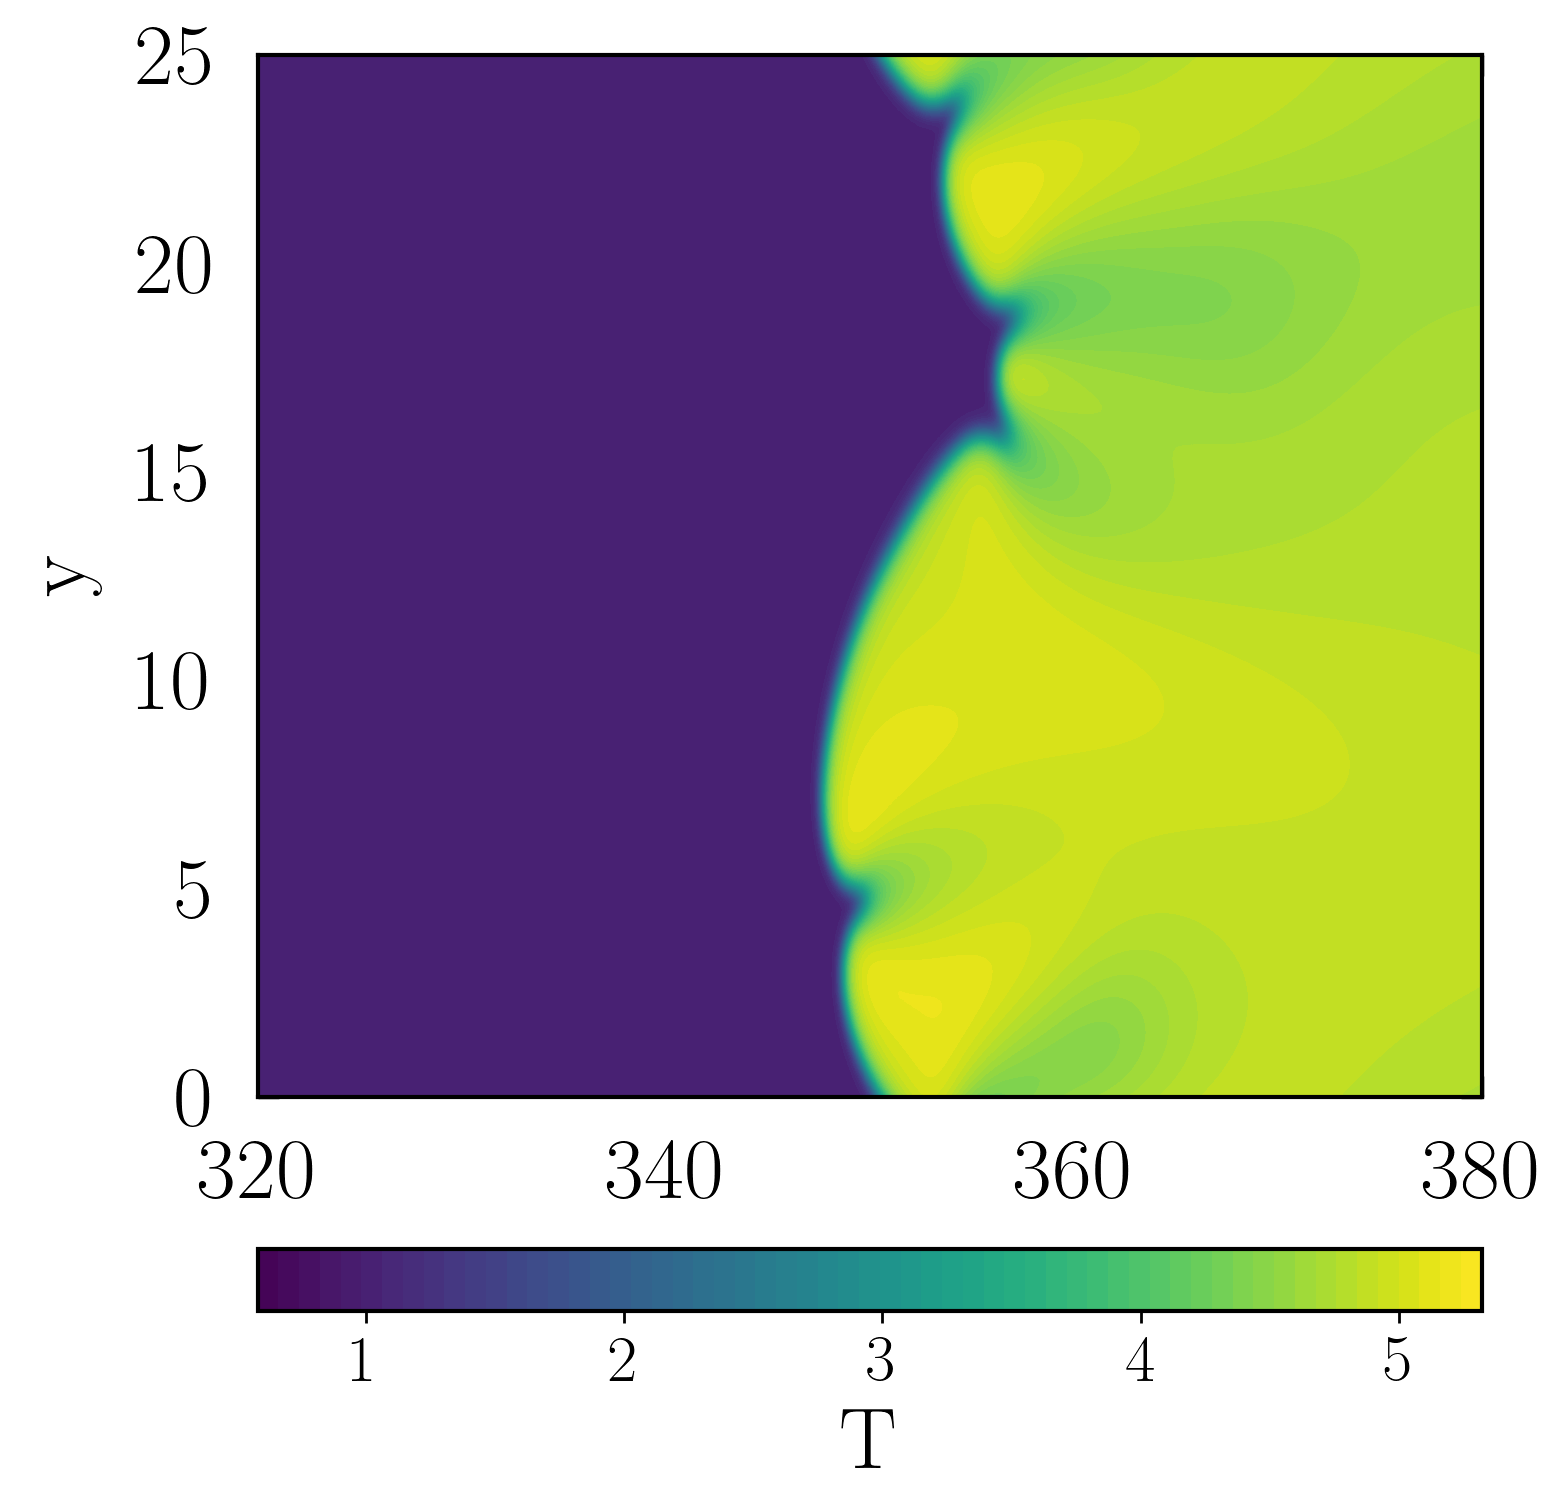

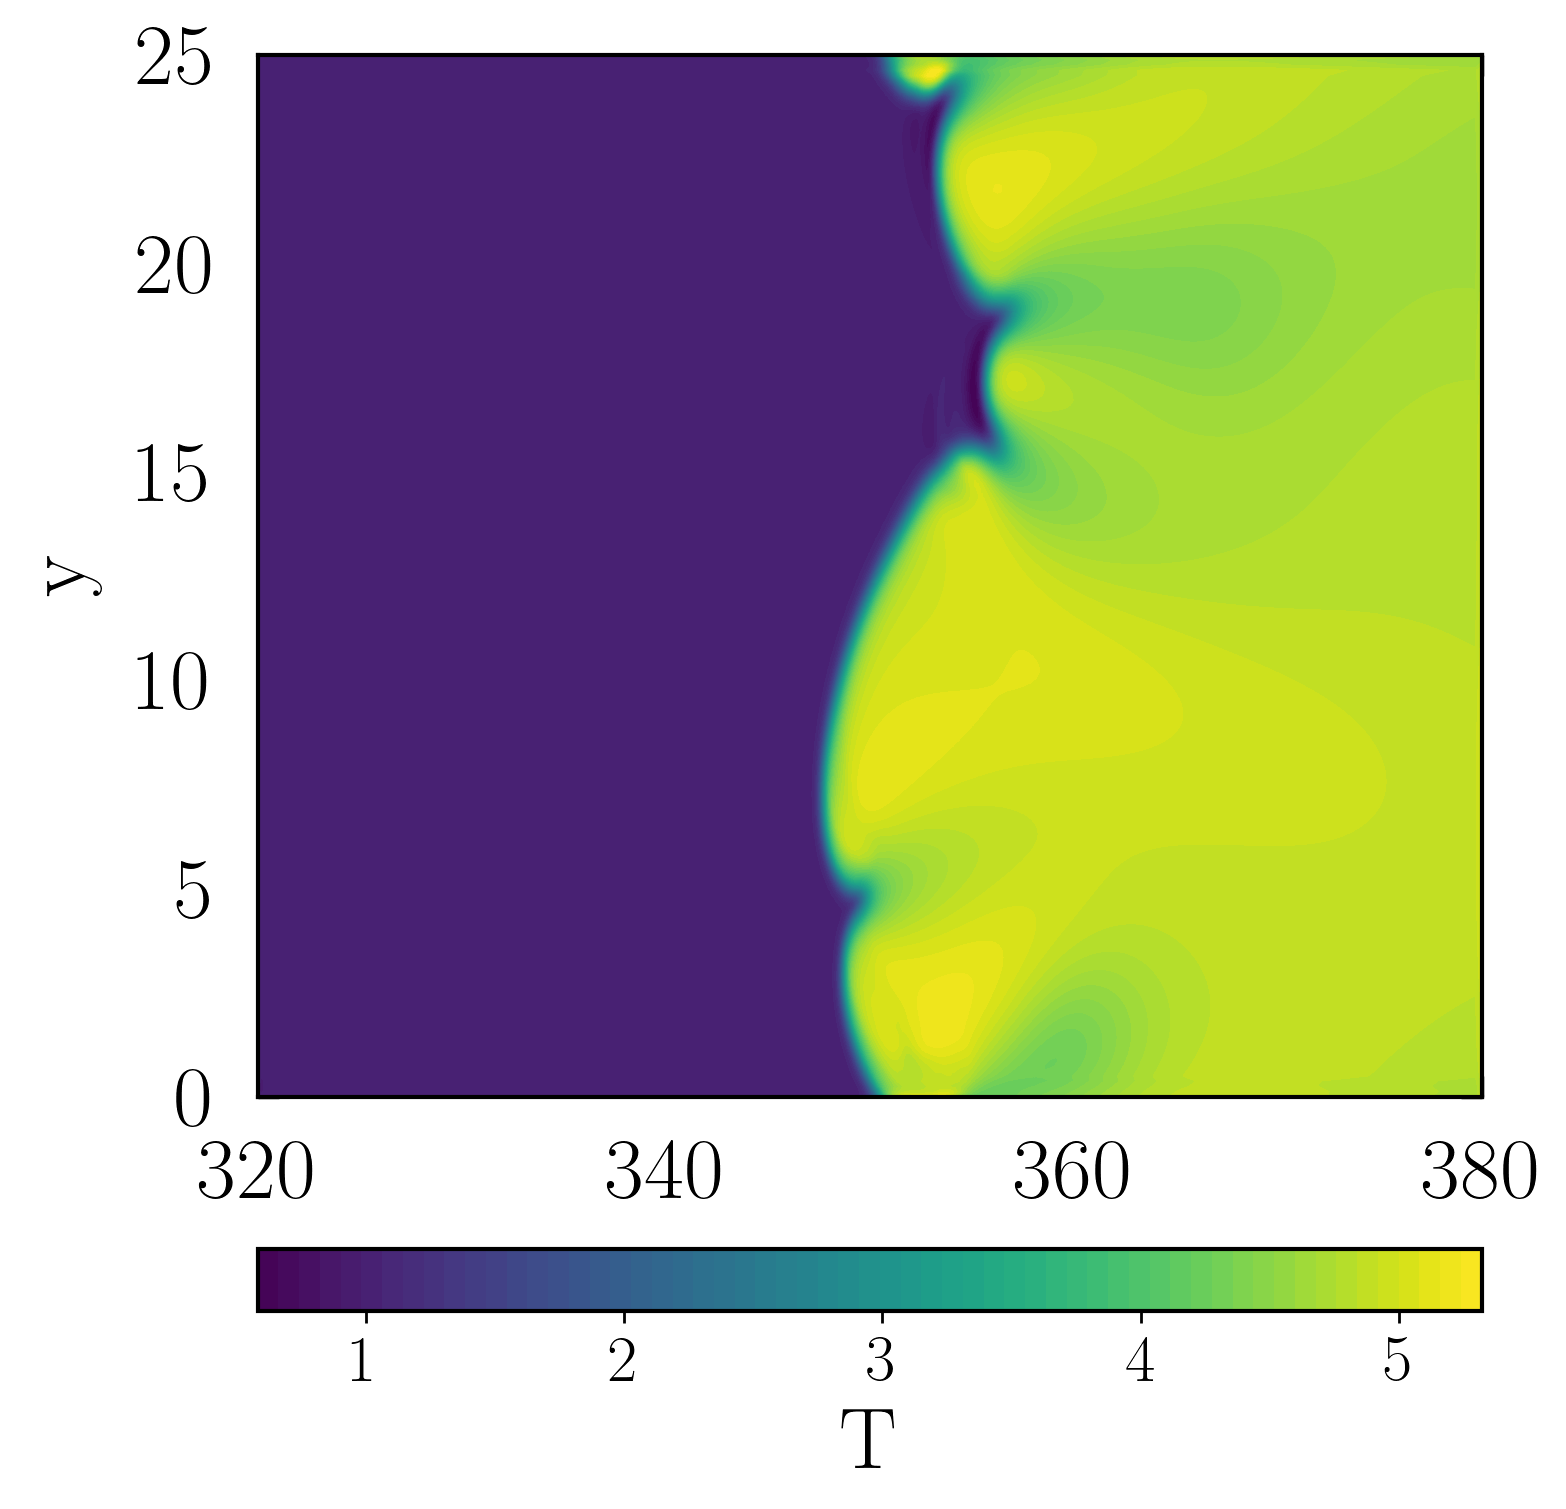

In [7]:


def _from_channels(arr: np.ndarray, shape: tuple[int, ...]) -> np.ndarray:
    if len(shape) == 2:
        return arr[0]
    if len(shape) == 3:
        return np.transpose(arr, (1, 2, 0))
    raise ValueError(f"Unsupported output shape: {shape}")

model.eval()
with torch.no_grad():
    last_idx = T - HISTORY - 1
    x_in = Xn[last_idx : last_idx + HISTORY]
    x_in = torch.from_numpy(x_in).reshape(1, -1, H, W).to(device)
    pred = model(x_in).cpu().numpy()[0]

pred_denorm = pred * X_std.squeeze(0) + X_mean.squeeze(0)
pred_field = _from_channels(pred_denorm, field_shape)

true_field = X[last_idx + HISTORY]
true_field_out = _from_channels(true_field, field_shape)

err = pred_denorm - true_field
rmse = float(np.sqrt(np.mean(err ** 2)))
ss_res = float(np.sum(err ** 2))
ss_tot = float(np.sum((true_field - true_field.mean()) ** 2))
r2 = 1.0 - ss_res / (ss_tot + 1.0e-12)

if rank == 0:
    print(
        f"One-step eval at index {last_idx + HISTORY}: RMSE={rmse:.6e}, R2={r2:.6e}"
    )

PRED_OUT_DIR = PROJECT_ROOT / Path(CFG.get("PRED_OUT_DIR", "data/fields/cnn_predictions"))
PRED_OUT_DIR.mkdir(parents=True, exist_ok=True)

t_pred = times[last_idx + HISTORY]
out_path = PRED_OUT_DIR / f"cnn_pred_{FIELD_NAME}_t{t_pred}.hdf5"

if rank == 0:
    with h5py.File(out_path, "w") as f:
        f.attrs["time"] = float(t_pred)
        f.create_dataset(FIELD_NAME, data=pred_field)
    print(f"Wrote prediction: {out_path}")

if rank == 0:
    import matplotlib.pyplot as plt
    import matplotlib.tri as mtri

    plot_slice = CFG.get("PLOT_SLICE_INDEX", None)
    x_plot = None
    y_plot = None

    if 'points_path' in globals() and Path(points_path).exists():
        with h5py.File(points_path, "r") as f:
            x = f["x"][:]
            y = f["y"][:]
            z = f["z"][:]
    else:
        x = y = z = None

    if pred_field.ndim == 2:
        pred_plot = pred_field
        true_plot = true_field_out
        if x is not None and x.ndim == 3:
            x_plot = x[:, :, 0]
            y_plot = y[:, :, 0]
        slice_label = ""
    elif pred_field.ndim == 3:
        z_idx = int(plot_slice) if plot_slice is not None else pred_field.shape[2] // 2
        z_idx = max(0, min(pred_field.shape[2] - 1, z_idx))
        pred_plot = pred_field[:, :, z_idx]
        true_plot = true_field_out[:, :, z_idx]
        if x is not None and x.ndim == 3:
            x_plot = x[:, :, z_idx]
            y_plot = y[:, :, z_idx]
        slice_label = f" (z index {z_idx})"
    else:
        raise ValueError(f"Unsupported field ndim={pred_field.ndim}")

    

    fig_true = plt.figure(figsize=FIG_SIZE, dpi=FIG_DPI)
    ax_true = fig_true.add_subplot(111)
    fig_pred = plt.figure(figsize=FIG_SIZE, dpi=FIG_DPI)
    ax_pred = fig_pred.add_subplot(111)

    if x_plot is not None:
        xx, yy = x_plot, y_plot
    else:
        xx, yy = np.meshgrid(
            np.arange(true_plot.shape[1], dtype=float),
            np.arange(true_plot.shape[0], dtype=float),
        )
    tri = mtri.Triangulation(xx.ravel(), yy.ravel())
    joint_min = float(min(true_plot.min(), pred_plot.min()))
    joint_max = float(max(true_plot.max(), pred_plot.max()))
    levels = np.linspace(joint_min, joint_max, 60)
    im_true = ax_true.tricontourf(tri, true_plot.ravel(), levels=levels, vmin=joint_min, vmax=joint_max, cmap=FIELD_CMAP, antialiased=False, linewidths=0)
    im_pred = ax_pred.tricontourf(tri, pred_plot.ravel(), levels=levels, vmin=joint_min, vmax=joint_max, cmap=FIELD_CMAP, antialiased=False, linewidths=0)
    _fix_tricontourf(im_true)
    _fix_tricontourf(im_pred)
    ax_true.tick_params(axis="both", which="both", pad=12)
    ax_true.set_xlabel(COORD_X, labelpad=10)
    ax_true.set_ylabel(COORD_Y, labelpad=10)
    ax_pred.tick_params(axis="both", which="both", pad=12)
    ax_pred.set_xlabel(COORD_X, labelpad=10)
    ax_pred.set_ylabel(COORD_Y, labelpad=10)
    style_axes(ax_true)
    style_axes(ax_pred)
    cbar_true = fig_true.colorbar(im_true, ax=ax_true, orientation="horizontal", pad=0.12, fraction=0.06)
    cbar_true.set_label(f"T")
    cbar_pred = fig_pred.colorbar(im_pred, ax=ax_pred, orientation="horizontal", pad=0.12, fraction=0.06)
    cbar_pred.set_label(f"T")
    style_colorbar(cbar_true)
    style_colorbar(cbar_pred)
    save_plot(fig_true, f"cnn_true_{FIELD_NAME}_t{t_pred}")
    save_plot(fig_pred, f"cnn_pred_{FIELD_NAME}_t{t_pred}")
    plt.show()



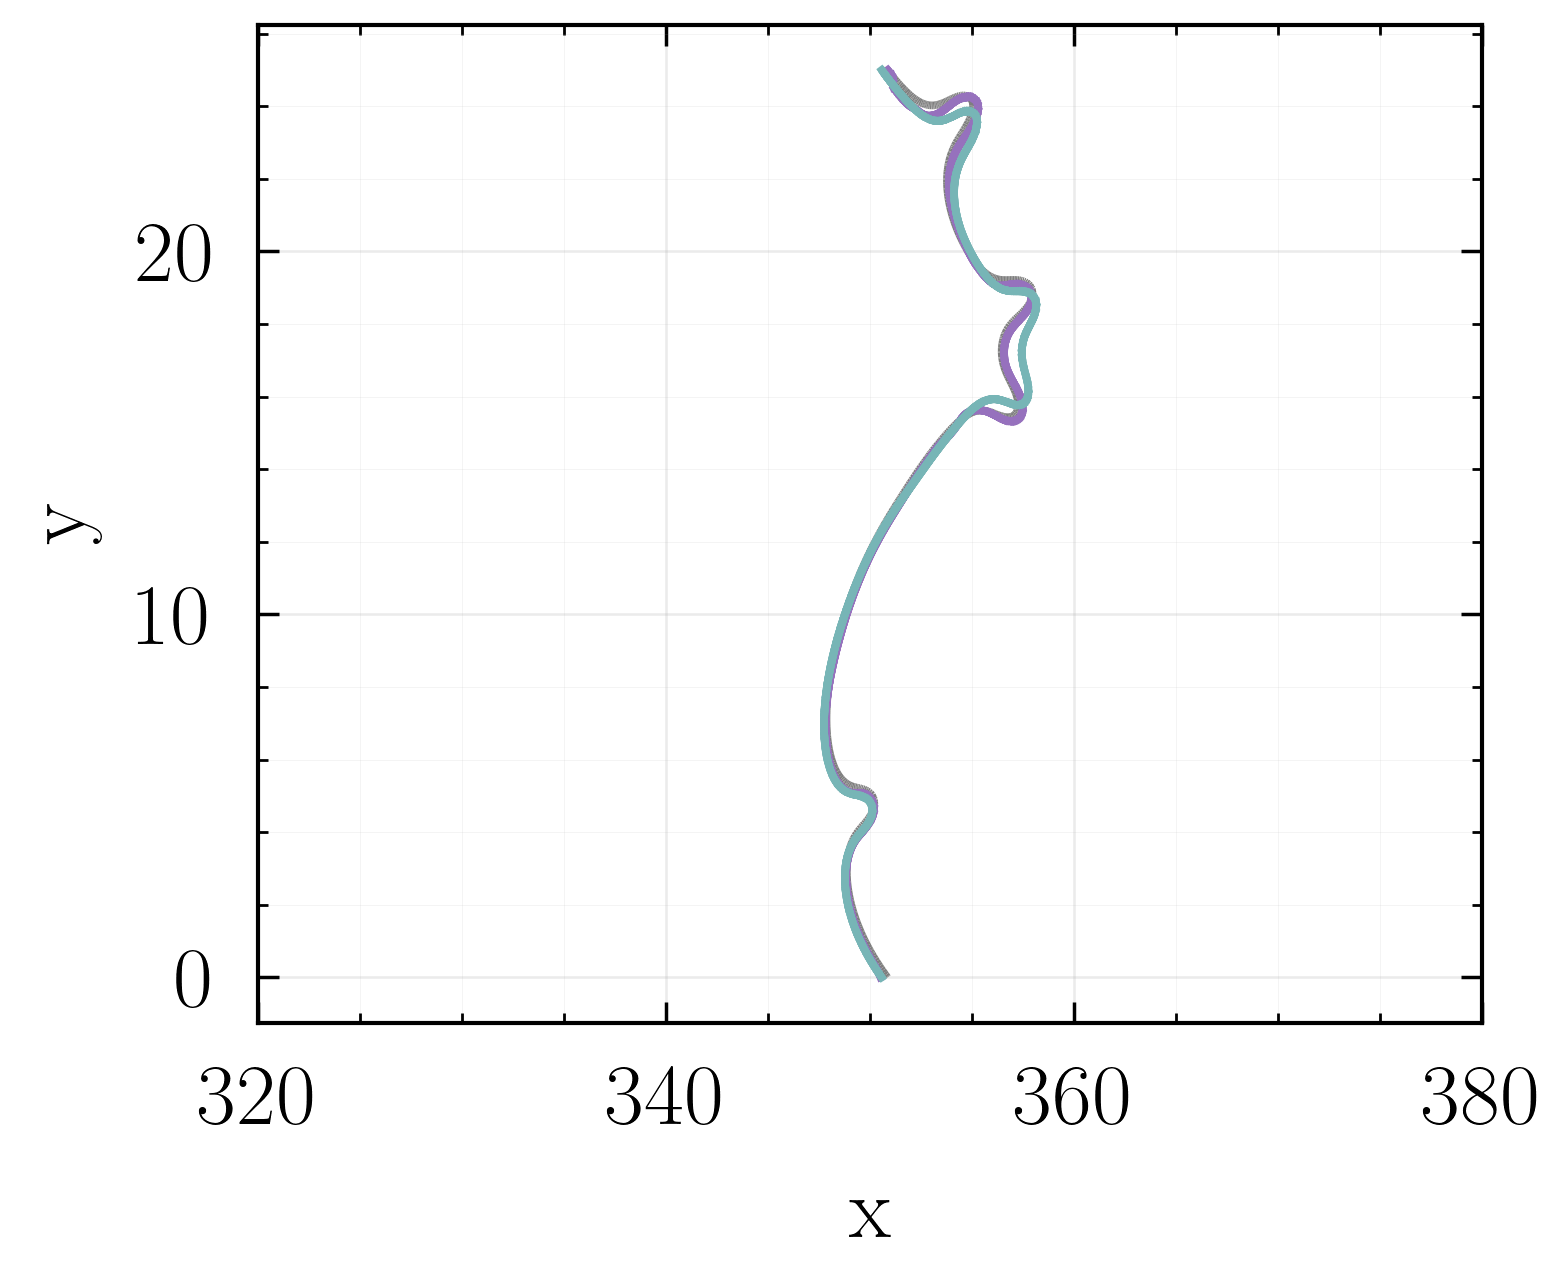

In [8]:
# Isotherm comparison (pred vs true) using PyVista.
import pyvista as pv
import numpy as np
import matplotlib.pyplot as plt

ISO_VALUE = CFG.get("ISO_VALUE", None)
if ISO_VALUE is None:
    raise ValueError("Set ISO_VALUE in CNN.yaml for isotherm extraction (ISO_VALUE).")
ISO_VALUE = float(ISO_VALUE)
ISO_FIG_SIZE = (FIG_SIZE[0], FIG_SIZE[1] / 1.18)  # match DMD isocontour sizing


XLIM_RAW = CFG.get("XLIM", None)
YLIM_RAW = CFG.get("YLIM", None)
if isinstance(XLIM_RAW, (list, tuple)) and len(XLIM_RAW) == 2:
    XLIM = (float(XLIM_RAW[0]), float(XLIM_RAW[1]))
else:
    XLIM = None
if isinstance(YLIM_RAW, (list, tuple)) and len(YLIM_RAW) == 2:
    YLIM = (float(YLIM_RAW[0]), float(YLIM_RAW[1]))
else:
    YLIM = None
use_pred_files = "pred_files" in globals() and len(pred_files) > 0


def _load_points_xyz():
    if not Path(points_path).exists():
        raise FileNotFoundError(f"Points file not found: {points_path}")
    with h5py.File(points_path, "r") as f:
        x = f["x"][:]
        y = f["y"][:]
        z = f["z"][:]
    return x, y, z


def _build_ugrid_xy(x_vals, y_vals):
    pts = np.column_stack([
        x_vals.astype(float),
        y_vals.astype(float),
        np.zeros_like(x_vals, dtype=float),
    ])
    poly = pv.PolyData(pts)
    mesh = poly.delaunay_2d()
    if hasattr(mesh, "cast_to_unstructured_grid"):
        return mesh.cast_to_unstructured_grid()
    return mesh


def _extract_isoline(grid, values, iso_value, label):
    if values.shape[0] != grid.n_points:
        raise ValueError(
            f"Scalar length {values.shape[0]} does not match grid points {grid.n_points}."
        )
    g = grid.copy(deep=True)
    g[label] = values
    return g.contour(isosurfaces=[iso_value], scalars=label)


def _contour_segments_xy(poly):
    if poly.n_points == 0:
        return []
    lines = np.asarray(poly.lines)
    if lines.size == 0:
        return []
    pts = np.asarray(poly.points)
    segments = []
    i = 0
    while i < lines.size:
        n = lines[i]
        idx = lines[i + 1 : i + 1 + n]
        segments.append(pts[idx, :2])
        i += n + 1
    return segments


def _plot_segments(ax, segments, *, label, color, linestyle="-", linewidth=LINE_WIDTH):
    if not segments:
        return False
    first = True
    for seg in segments:
        ax.plot(
            seg[:, 0],
            seg[:, 1],
            color=color,
            linestyle=linestyle,
            linewidth=linewidth,
            label=label if first else None,
        )
        first = False
    return True


# Decide which fields to compare
if use_pred_files:
    pred_start = int(CFG.get("PRED_START_INDEX", 0) or 0)
    if pred_start < 0 or pred_start >= T_pred:
        raise ValueError(f"PRED_START_INDEX must be in [0, {T_pred - 1}] when using prediction files.")

    history = Xn[-HISTORY:].copy()
    if pred_start > 0:
        for i in range(pred_start):
            true_step = X_pred[i]
            true_norm = (true_step - X_mean.squeeze(0)) / X_std.squeeze(0)
            history = np.concatenate([history[1:], true_norm[None, ...]], axis=0)

    model.eval()
    with torch.no_grad():
        x_in = torch.from_numpy(history).reshape(1, -1, H, W).to(device)
        pred = model(x_in).cpu().numpy()[0]

    pred_denorm = pred * X_std.squeeze(0) + X_mean.squeeze(0)
    true_eval = X_pred[pred_start]
    pred_eval_field = _from_channels(pred_denorm, field_shape)
    true_eval_field = _from_channels(true_eval, field_shape)
    prev_eval_field = None
    if pred_start > 0:
        prev_eval_field = _from_channels(X_pred[pred_start - 1], field_shape)
    else:
        prev_eval_field = _from_channels(X[-1], field_shape)
    stem = f"cnn_isotherm_iso{ISO_VALUE:g}_t{pred_times[pred_start] if pred_times else pred_start}"
else:
    pred_eval_field = pred_field
    true_eval_field = true_field_out
    prev_eval_field = _from_channels(X[last_idx + HISTORY - 1], field_shape)
    stem = f"cnn_isotherm_iso{ISO_VALUE:g}_t{t_pred if 't_pred' in globals() else 'pred'}"


# Load grid and take a slice if needed
xg, yg, zg = _load_points_xyz()

if pred_eval_field.ndim == 2:
    if xg.ndim == 3 and xg.shape[2] == 1:
        x_slice = xg[:, :, 0]
        y_slice = yg[:, :, 0]
    else:
        x_slice, y_slice = xg, yg
    pred_vals = pred_eval_field
    true_vals = true_eval_field
    prev_vals = prev_eval_field
elif pred_eval_field.ndim == 3:
    z_idx_cfg = CFG.get("PLOT_SLICE_INDEX", None)
    z_idx = int(z_idx_cfg) if z_idx_cfg is not None else pred_eval_field.shape[2] // 2
    z_idx = max(0, min(pred_eval_field.shape[2] - 1, z_idx))
    x_slice = xg[:, :, z_idx]
    y_slice = yg[:, :, z_idx]
    pred_vals = pred_eval_field[:, :, z_idx]
    true_vals = true_eval_field[:, :, z_idx]
    prev_vals = prev_eval_field[:, :, z_idx] if prev_eval_field is not None else None
else:
    raise ValueError(f"Unsupported field ndim={pred_eval_field.ndim}.")


# Build unstructured grid on XY (match DMD isocontour style)
grid = _build_ugrid_xy(x_slice.ravel(order="F"), y_slice.ravel(order="F"))

pred_flat = np.ascontiguousarray(pred_vals).ravel(order="F")
true_flat = np.ascontiguousarray(true_vals).ravel(order="F")
prev_flat = np.ascontiguousarray(prev_vals).ravel(order="F") if prev_vals is not None else None

segments_pred = _contour_segments_xy(_extract_isoline(grid, pred_flat, ISO_VALUE, "pred"))
segments_true = _contour_segments_xy(_extract_isoline(grid, true_flat, ISO_VALUE, "true"))
segments_prev = []
if prev_flat is not None:
    segments_prev = _contour_segments_xy(_extract_isoline(grid, prev_flat, ISO_VALUE, "prev"))


if rank == 0:
    fig = plt.figure(figsize=ISO_FIG_SIZE, dpi=FIG_DPI)
    fig.subplots_adjust(bottom=0.2)
    ax = fig.add_subplot(111)
    if segments_prev:
        _plot_segments(ax, segments_prev, label="prev", color=COLOR_NEUTRAL, linestyle="--", linewidth=LINE_WIDTH)
    _plot_segments(ax, segments_pred, label="pred", color=COLOR_PRED, linestyle="-", linewidth=LINE_WIDTH)
    _plot_segments(ax, segments_true, label="true", color=COLOR_DATA, linestyle="-", linewidth=LINE_WIDTH)
    ax.tick_params(axis="both", which="both", pad=12)
    ax.set_xlabel(COORD_X, labelpad=10)
    ax.set_ylabel(COORD_Y, labelpad=10)
    if XLIM is not None:
        ax.set_xlim(XLIM)
    if YLIM is not None:
        ax.set_ylim(YLIM)
    style_axes(ax)
    save_plot(fig, stem)
    plt.show()


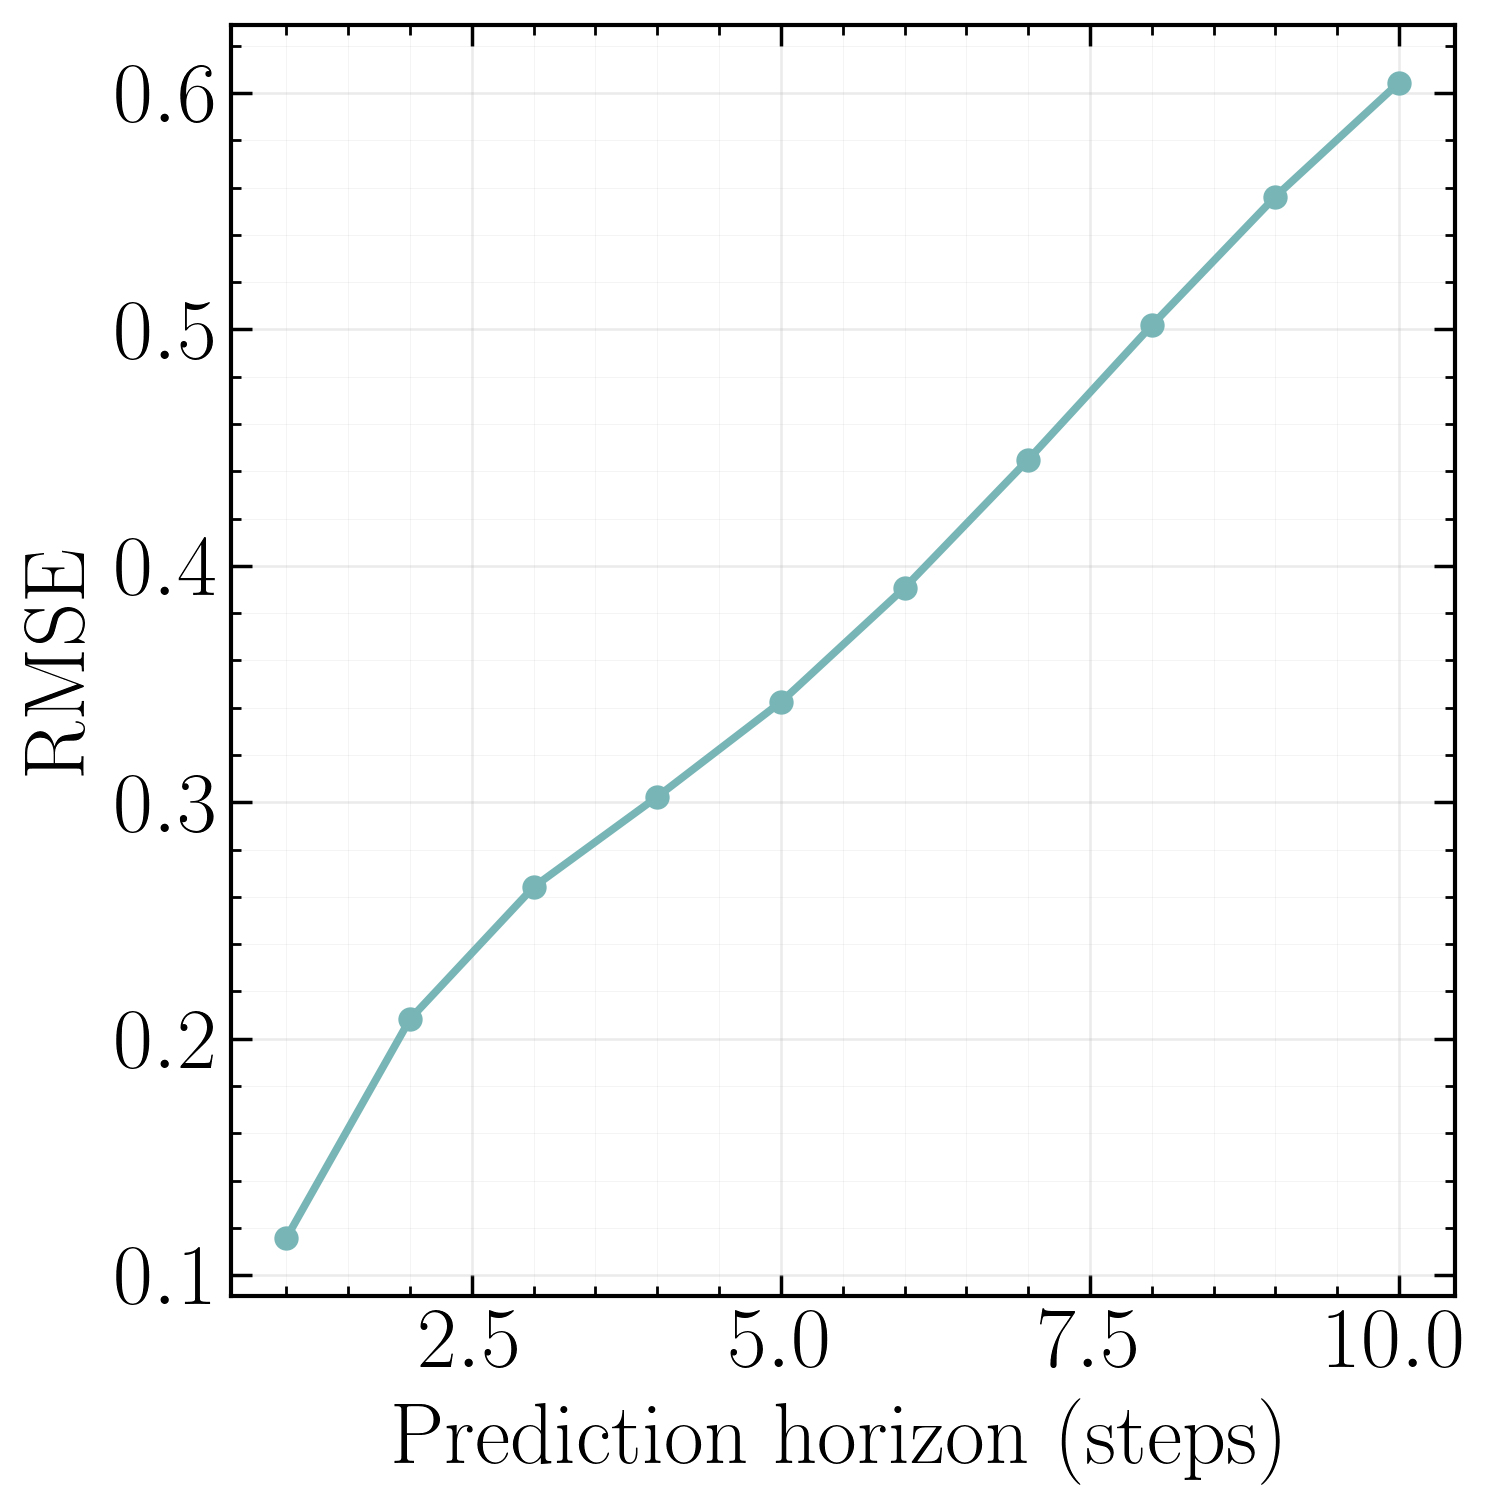

In [9]:
# Prediction window analysis (autoregressive rollout).
PRED_WINDOW = int(CFG.get("PRED_WINDOW", 5) or 5)
PRED_START = CFG.get("PRED_START_INDEX", None)

use_pred_files = "pred_files" in globals() and len(pred_files) > 0

    

if use_pred_files:
    pred_start = int(PRED_START) if PRED_START is not None else 0
    if pred_start < 0 or pred_start >= T_pred:
        raise ValueError(
            f"PRED_START_INDEX must be in [0, {T_pred - 1}] when using prediction files."
        )
    if PRED_WINDOW is None:
        PRED_WINDOW = T_pred - pred_start
    PRED_WINDOW = int(PRED_WINDOW)
    if PRED_WINDOW < 1 or pred_start + PRED_WINDOW > T_pred:
        raise ValueError(
            f"Prediction window exceeds available prediction data: start={pred_start}, "
            f"PRED_WINDOW={PRED_WINDOW}, T_pred={T_pred}."
        )

    history = Xn[-HISTORY:].copy()
    if pred_start > 0:
        for i in range(pred_start):
            true_step = X_pred[i]
            true_norm = (true_step - X_mean.squeeze(0)) / X_std.squeeze(0)
            history = np.concatenate([history[1:], true_norm[None, ...]], axis=0)

    rmse_h = []
    r2_h = []
    model.eval()
    with torch.no_grad():
        for h in range(1, PRED_WINDOW + 1):
            x_in = torch.from_numpy(history).reshape(1, -1, H, W).to(device)
            pred = model(x_in).cpu().numpy()[0]
            pred_denorm = pred * X_std.squeeze(0) + X_mean.squeeze(0)
            true = X_pred[pred_start + h - 1]
            err = pred_denorm - true
            rmse = float(np.sqrt(np.mean(err ** 2)))
            ss_res = float(np.sum(err ** 2))
            ss_tot = float(np.sum((true - true.mean()) ** 2))
            r2 = 1.0 - ss_res / (ss_tot + 1.0e-12)
            rmse_h.append(rmse)
            r2_h.append(r2)
            history = np.concatenate([history[1:], pred[None, ...]], axis=0)
    if rank == 0:

        import matplotlib.pyplot as plt

        horizons = np.arange(1, PRED_WINDOW + 1)

        fig, ax1 = plt.subplots(figsize=FIG_SIZE, dpi=FIG_DPI)

        ax1.plot(horizons, rmse_h, "o-", label="RMSE", color=COLOR_DATA, linewidth=LINE_WIDTH)

        ax1.set_xlabel("Prediction horizon (steps)")

        ax1.set_ylabel("RMSE")

        style_axes(ax1)

        
        save_plot(fig, f"cnn_pred_window_rmse_r2_start{pred_start}_len{PRED_WINDOW}")
        plt.show()
else:
    if PRED_WINDOW is None:
        PRED_WINDOW = min(50, T - HISTORY - 1)
    PRED_WINDOW = int(PRED_WINDOW)
    if PRED_WINDOW < 1:
        raise ValueError("PRED_WINDOW must be >= 1.")

    if PRED_START is None:
        start_idx = max(0, T - HISTORY - PRED_WINDOW)
    else:
        start_idx = int(PRED_START)

    if start_idx + HISTORY + PRED_WINDOW > T:
        raise ValueError(
            f"Prediction window exceeds available data: start={start_idx}, "
            f"HISTORY={HISTORY}, PRED_WINDOW={PRED_WINDOW}, T={T}."
        )

    history = Xn[start_idx : start_idx + HISTORY].copy()
    rmse_h = []
    r2_h = []

    model.eval()
    with torch.no_grad():
        for h in range(1, PRED_WINDOW + 1):
            x_in = torch.from_numpy(history).reshape(1, -1, H, W).to(device)
            pred = model(x_in).cpu().numpy()[0]
            pred_denorm = pred * X_std.squeeze(0) + X_mean.squeeze(0)
            true = X[start_idx + HISTORY + h - 1]
            err = pred_denorm - true
            rmse = float(np.sqrt(np.mean(err ** 2)))
            ss_res = float(np.sum(err ** 2))
            ss_tot = float(np.sum((true - true.mean()) ** 2))
            r2 = 1.0 - ss_res / (ss_tot + 1.0e-12)
            rmse_h.append(rmse)
            r2_h.append(r2)
            history = np.concatenate([history[1:], pred[None, ...]], axis=0)
    if rank == 0:

        import matplotlib.pyplot as plt

        horizons = np.arange(1, PRED_WINDOW + 1)

        fig, ax1 = plt.subplots(figsize=FIG_SIZE, dpi=FIG_DPI)

        ax1.plot(horizons, rmse_h, "o-", label="RMSE", color=COLOR_DATA, linewidth=LINE_WIDTH)

        ax1.set_xlabel("Prediction horizon (steps)")

        ax1.set_ylabel("RMSE")

        style_axes(ax1)
        
        save_plot(fig, f"cnn_pred_window_rmse_r2_start{start_idx}_len{PRED_WINDOW}")
        plt.show()
